# Theoretical task

Target variable $y\sim Laplace(\alpha, \beta)$, $p(y = z) = \frac{1}{2\beta}exp(-\frac{|{z-\alpha}|}{\beta})$, with $\mathrm{E}[y] = \alpha$ and $\mathrm{Var}[y] = 2\beta^2$.  
Let $x_{(m\times n)}$ - our data, $\theta_{(n\times1)}$ - vector of parameters.  
Then $y$ may be represented as $f(x) = x\theta + \xi$,  
where $\xi\sim N(0, \sigma^2)$, and $\mathrm{E}[f(x)] = x\theta$, $\mathrm{Var}[f(x)] = \sigma^2$.
Hence, $\alpha = x\theta$ and $2\beta^2 = \sigma^2$  

So if we want to maximize likelihood, then:  

$p(t|x, \theta, \sigma^2) = \prod \limits_{i=1}^m\frac{1}{2\beta}exp(-\frac{|{t_i-\alpha}|}{\beta}) = \prod \limits_{i=1}^m\frac{1}{\sigma\sqrt{2}}exp(-\frac{\sqrt{2}|{t_i-x_i\theta}|}{\sigma})$  
$\ln{p(t|x, \theta, \sigma^2)} = -\sum \limits_{i=1}^m\frac{\sqrt{2}|{t_i-x_i\theta}|}{\sigma} + m\ln{\frac{1}{\sigma\sqrt{2}}}$  
Assuming that $\sigma$ doesn't depend on target values, optimal $\theta = argmin \sum \limits_{i=1}^m|{t_i-x_i\theta}|$.  

So if our target values have Laplace distribution, then we need to use _MAE_ as our _loss function_.

### Bayesian approach
In the case of _Bayesian approach_ we will maximize _posterior probability_ $p(\theta|x) = \frac{p(x|\theta)p(\theta)}{p(x)}$.  
Hence, in this case we take into account distribution of our parameters $\theta$.  


$\ln{p(\theta|t)} = -\sum \limits_{i=1}^m\frac{\sqrt{2}|{t_i-x_i\theta}|}{\sigma} + m\ln{\frac{1}{\sigma\sqrt{2}}} + \ln{p(\theta)}$

$\theta\sim Laplace(\mu = 0, \frac{\Sigma}{\lambda})$, where $\mu$ is a vector of mean values of $\theta$ and  
$\Sigma$ - identity matrix of covariance.

$p(\theta_{n\times1}) = \displaystyle f_{\mathbf {\theta} }(\theta_{1},\ldots ,\theta_{n})={\frac {2\sqrt{\lambda}}{(2\pi )^{n/2}|{\boldsymbol {\Sigma }}|^{0.5}}}\left({\frac {\lambda\mathbf {\theta}^{T}{\boldsymbol {\Sigma }}^{-1}\mathbf {\theta} }{2}}\right)^{v/2}K_{v}\left({\sqrt {2\mathbf {\theta}^T{\lambda\boldsymbol {\Sigma }}^{-1}\mathbf {\theta} }}\right)$  
$\displaystyle v=(2-n)/2$.  
$\displaystyle K_v$ is the modified Bessel function of the second kind.

$\ln{p(\theta)} = \ln{\frac{2}{(2\pi)^k/2}} + \frac{\displaystyle v}{2}\ln{(\lambda\frac{\theta^T\theta}{2})} + \ln{K_{v}\left({\sqrt {2\mathbf {\theta}^T{\lambda}\mathbf {\theta} }}\right)}$  

Hence $\theta = argmin \sum \limits_{i=1}^m|{t_i-x_i\theta}| + \ln{(\lambda\frac{\theta^T\theta}{2})} + \ln{K_{v}\left({\sqrt {2\mathbf {\theta}^T{\lambda}\mathbf {\theta} }}\right)}$
Вот что делать с $K_v$ я не знаю

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

# ------------------------------------------------MODEL----------------------------------------------------
We will build _3-layer perceptron_ which will be trained, using _MNIST digits dataset_, to distinguish handwritten digits.  

We'll follow the next steps:  

1. Loading data  


2. Feature analysis and engineering  


3. Building the model:
    * Define activation functions and hidden layers sizes
    * Define the _loss function_
    * Define _learning algorithm_  
    * Implement through the code


4. Train the model  


5. Evaluate perfomance and optimize it  


6. Make prediction

# 1.Loading data  

In [2]:
mnist = np.load('./mnist.npz')
x_train = mnist['x_train']
y_train = mnist['y_train']
x_test = mnist['x_test']
y_test = mnist['y_test']
print('Train shape: {}, Test shape: {}'.format(x_train.shape, x_test.shape))

Train shape: (60000, 28, 28), Test shape: (10000, 28, 28)


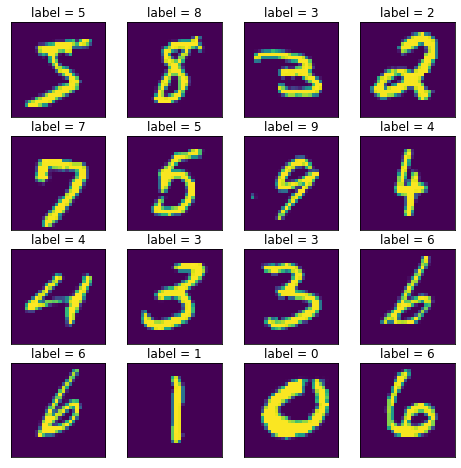

In [3]:
fig, ax = plt.subplots(4, 4, figsize = (8, 8))
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(x_train[371*i + 125*j])
        ax[i, j].set_title('label = %s' % y_train[371*i + 125*j])
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

Data consists of 70000 samples.  
Each sample is a 28x28 gray-scale image of a digit from 0 to 9. 

For convenience each image will be reshaped from 28x28 matrix into 28^2 = 784-element row.  
Hence $x_{j}^{(i)}$ ($x_{ij}$ element of matrix *x_train*) represents _jth_ feature of _ith_ sample, or a single pixel of _(ith)_ image, _j_ goes from 1 to 784,  
$x_0$ will represent _bias term_,  
and $x^{(i)}$ is a row vector of features of _ith_ sample.   

Each pixel has a single pixel-value from 0 to 255 associated with it,  
indicating the lightness or darkness of that pixel, with higher number meaning lighter.  

In [4]:
x_train = x_train.reshape(x_train.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], 1)

x_test = x_test.reshape(x_test.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], 1)

print('Reshaped:')
print('Train shape: {}, Test shape: {}'.format(x_train.shape, x_test.shape))
x_train

Reshaped:
Train shape: (60000, 784), Test shape: (10000, 784)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

# 2.Feature analysis and engineering

Data should be normalized

In [5]:
def normalize_data(x1, x2 = None):
    '''
    Arguments:
    x -- data tuple, e.g. (x_train, x_test)
    
    Returns:
    x_normalized -- (x-Ex)/std(x)
    '''
    if x2 is not None:
        x = np.concatenate((x1, x2), axis = 0)    
    else:
        x = x1.copy()
    
    Ex = np.mean(x, axis = 0)
    std_x = np.std(x, axis = 0)
    
    x1_normalized = (x1 - Ex) / (std_x + 1e-10) # add 1e-10 to avoid division by zero
    x2_normalized = (x2 - Ex) / (std_x + 1e-10)
    
    return x1_normalized, x2_normalized

In [6]:
x_train, x_test = normalize_data(x_train, x_test)

Target values *y_train* and *y_test* are now cosists of digits from _0_ to _9_,  

it's not convenient to use this form for training, so we'll use _one-hot encoding_.

If $y^{(i)} = 4$, then after encoding $y^{(i)} = (0, 0, 0, 1, 0, 0, 0, 0, 0, 0)$,  

and target vector $y_{m\times1}$ after ecnoding will have shape $(m, K)$, where $K$ - number of classes

In [7]:
def one_hot(y, K):
    '''
    Argumnets:
    y -- target vector
    K -- number of classes
    
    Returns:
    y_ext -- one-hot encoded vector y
    '''
    # expand the array
    zero_pad = np.zeros((y.shape[0], K - 1))
    y_ext = np.concatenate((y, zero_pad), axis = 1)
    
    # One-hot encoding
    for i in range(y.shape[0]):
        for j in range(K):
            
            y_ext[i, j] = 1 if y[i] == j else 0
    
    return y_ext

In [8]:
K = 10 # number of classes

y_train = one_hot(y_train, K)
y_test = one_hot(y_test, K)
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

Now $y_{j}^{(i)}$ represents _ith_ image with digit equals to _j_, if $y_{j}^{(i)}$ = 1. Other values of row $y^{(i)}$ equals zero.

Let's divide *x_train* into _training set_ and _cross-validation set_.

In [9]:
# Cross-validation set
x_valid = x_train[50000:]
y_valid = y_train[50000:]
# Training set
x_train = x_train[:50000]
y_train = y_train[:50000]

print('Training set shape: {} Dev set shape: {}'.format(x_train.shape, x_valid.shape))

Training set shape: (50000, 784) Dev set shape: (10000, 784)


For neural networks data should have shape $(n, m)$, where _n_ is a number of features and _m_ is a number of training examples.  
So we should transpose our data.

# Building the model
We'll build 3-layer perceptron and train it with _Adam algorithm_.

#### Network architecture:

- _Input layer_ is our data $x_{n\times1}^{(i)}$  
- _Hidden layer_ with *tanh* activation function  
- _Output layer_ with _softmax_ activation function.  

Predicted target variable may be represented as:  
$F(x) = \Psi\left(\phi\left( {x}W_1 + b_1 \right)W_2 + b_2\right)$  
Where $\Psi$ - _softmax_ function, $\phi$ - _tanh_   

Target variable $y$ has _multinomial distribution_ so we can use _cross entropy_ as our _loss function_.

_Loss function and gradients_:
1. $\mathcal{L} = -\frac{1}{m}\sum^{m}_{i=1} {\sum^{K}_{j=1} ({y_{j}^{(i)}\ln{\hat{y}_{j}^{(i)}})}}$, where $\hat{y}_{j}^{(i)}$ is predicted target variable
2. Each layer has its matrix of parameters $W$ and $b$ of _ith_ layer, $W^{(i)}$ and $b^{(i)}$ is a matrix of parameters of the _$ith$_ hidden layer. $(b^{(i)}, W^{(i)}) = \begin{pmatrix}
b_{1}^{(i)} & W_{11}^{(i)} & W_{12}^{(i)} & ...\\
b_{2}^{(i)} & W_{21}^{(i)} & W_{22}^{(i)} & ...\\
b_{3}^{(i)} & W_{31}^{(i)} & W_{32}^{(i)} & ...\\
.                 & .                 & .            \\
\end{pmatrix}$  
Shape of $W^{(i)}$ is $(n_{i}, n_{i-1})$, shape of $b^{(i)}$ is $(n_{i}, 1)$ where $n_i$ is number of nodes in _ith_ layer. Input layer is _0th_ layer.  

### Train loop
1. Initialize hyperparameters  


2. Train loop:
    * Compute target values $\hat{y}^{(i)}$
    * Compute _loss_ $\mathcal{L} = -\frac{1}{m}\sum^{m}_{i=1} {\sum^{K}_{j=1} ({y_{j}^{(i)}\ln{\hat{y}_{j}^{(i)}})}}$
    * Compute gradients $\frac{\partial\mathcal{L}}{\partial\Theta_{jk}^{(i)}}$
    * Update parameters 
        - $W_{jk}^{(i)} = W_{jk}^{(i)} - \alpha\frac{\partial\mathcal{L}}{\partial W_{jk}^{(i)}}$     
        - $b_{j}^{(i)} = b_{j}^{(i)} - \alpha\frac{\partial\mathcal{L}}{\partial b_{j}^{(i)}}$

In [10]:
def random_mini_batches(X, Y, mini_batch_size = 256):
    """
    Create a list of random mini batches from (X, Y)
    
    Arguments:
    X - dataset, size = (n, m)
    Y - label vecor, size = (number of labels, m)
    
    Return:
    mini_batches - list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]
    mini_batches = list()
    
    permutation = list(np.random.permutation(m)) # create a list of permutations
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0], m))
    
    # Partition
    num_complete_minibatches = np.floor(m/mini_batch_size).astype(int)
    for k in range(num_complete_minibatches):
        
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    # Handling the end casse (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        
        mini_batch_X = shuffled_X[:, mini_batch_size*(m // mini_batch_size) : ]
        mini_batch_Y = shuffled_Y[:, mini_batch_size*(m // mini_batch_size) : ]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches

In [11]:
class Differentiable:
    def __init__(self):
        self.state = None
        
    def forward(self, **kwargs):
        raise NotImplementedError()
    def backward(self, **kwargs):
        raise NotImplementedError()

In [12]:
class loss(Differentiable):
    def __init__(self):
        super().__init__()
        
    def forward(self, **kwargs):
        
        self.state = 0.0
        
        loss_value = -1/kwargs['y'].shape[1] * np.sum(kwargs['y'] * np.log(kwargs['y_pred']))
        
        self.state = (kwargs['y'], kwargs['y_pred'])
        
        return loss_value
    
    def backward(self, **kwargs):
        
        partial_grad = -1/self.state[0].shape[1] * (self.state[1] / self.state[1])
        
        return partial_grad

In [13]:
class Linear(Differentiable):
    def __init__(self, dim):
        super().__init__()
        self.parameters = {'W' : None, 'b' : None}
        self.dim = dim # shape of W, W.shape = (n_(i), n_(i-1)), where i is a number of the layer
        
    def __call__(self, X):
        return self.forward(X)
    
    def backward(self, **kwargs):
        
        partial_grad = self.state
        
        return partial_grad
    
    def forward(self, X):
        
        assert X.ndim == 2, 'X be should 2-dimensional (m of objects, n of features)'
        
        if self.parameters['W'] is None or self.parameters['b'] is None:
            self.parameters['W'] = np.random.randn(self.dim[0], self.dim[1]) * 0.01
            self.parameters['b'] = np.zeros((self.dim[0], 1))
            
        self.state = X.T
            
        y_pred = np.dot(self.parameters['W'], X) + self.parameters['b']
        
        return y_pred

In [14]:
class Activation(Differentiable):
    def __init__(self):
        super().__init__()
        self.parameters = None
    
    def backward(self, **kwargs):
        
        partial_grad = 1- self.state**2
        
        return partial_grad
    
    def forward(self, **kwargs):
        
        y_pred = np.tanh(kwargs['Z'])
        
        self.state = y_pred
        
        return y_pred
    
    def _sigmoid(self, Z):
        
        return 1/(1 + np.exp(-Z))

In [15]:
class Softmax(Differentiable):
    def __init__(self):
        super().__init__()
        self.parameters = None
        
    def __call__(self, **kwargs):
        return self.forward(X)
    
    def backward(self, **kwargs):
        
        
        y = kwargs['y']
        partial_grad = self.state * (self.state - y)
        
        return partial_grad
    
    def forward(self, **kwargs):
        
        y_pred = np.exp(kwargs['Z']) / np.sum(np.exp(kwargs['Z']), axis = 0)
        self.state = y_pred
        return y_pred

In [16]:
class Perceptron(Differentiable):
    def __init__(self, dims):
        super().__init__()
        
        self.parameters = dict()
        
        self.dims = dims
        
        self.layer1 = Linear(dim = (self.dims[1], self.dims[0]))# linear function of layer 1
        
        self.layer1_act = Activation() # activation function of layer 1
        
        self.output = Linear(dim = (self.dims[2], self.dims[1])) # linear function of the output layer
                             
        self.output_act = Softmax() # activation function of the output layer
        
    def __call__(self, **kwargs):
        return self.forward(X)
    
    def backward(self, **kwargs):
        
        loss_grad = kwargs['loss_grad']
        y = kwargs['y']
        
        partial_grad1 = np.dot(loss_grad * self.output_act.backward(y = y) * self.layer1_act.backward(), self.layer1.backward())
        partial_grad2 = np.dot(loss_grad * self.output_act.backward(y = y), self.output.backward())
        
        grads = {'dW1' : partial_grad1, 'dW2' : partial_grad2}
        
        return grads
    
    def forward(self, **kwargs):
        
        X = kwargs['X']
        
        Z1 = self.layer1(X)
        A1 = self.layer1_act.forward(Z = Z1)
        Z2 = self.output(A1)
        A2 = self.output_act.forward(Z = Z2)
        
        self.state = A2
        
        y_pred = A2
        
        return y_pred
    
    
    def update_parameters(self, learning_rate, grads):
        
        self.parameters['W1'] = self.layer1.parameters['W']
        self.parameters['b1'] = self.layer1.parameters['b']
        
        self.parameters['W2'] = self.output.parameters['W']
        self.parameters['b2'] = self.output.parameters['b']
        
        self.parameters['W1'] = self.parameters['W1'] - learning_rate * grads['dW1']
        self.parameters['W2'] = self.parameters['W2'] - learning_rate * grads['dW2']
        
        self.layer1.parameters['W'] = self.parameters['W1']
        self.layer1.parameters['b'] = self.parameters['b1']
        
        self.output.parameters['W'] = self.parameters['W2']
        self.output.parameters['b'] = self.parameters['b2']

In [17]:
def train_loop(X, y, model, loss_fn, epochs=100, learning_rate = 0.0001, mini_batch_size = 256):
    
    loss_history = list()
    pbar = tqdm(total = epochs)
    grads = {'dW1' : None, 'dW2' : None}
    
    for epoch in range(epochs):
        
        minibatches = random_mini_batches(X, y, mini_batch_size)
        loss_value = 0
        
        for minibatch in minibatches:
        
            (minibatch_X, minibatch_Y) = minibatch
            
            y_pred = model.forward(X = minibatch_X)
        
            loss_value += loss_fn.forward(y = minibatch_Y, y_pred = y_pred)
        
            loss_grad = loss_fn.backward()
        
            grads['dW1'] = model.backward(loss_grad = loss_grad, y = minibatch_Y)['dW1']
            grads['dW2'] = model.backward(loss_grad = loss_grad, y = minibatch_Y)['dW2']
        
        
            model.update_parameters(learning_rate, grads)
            
        loss_value /= X.shape[1]
        loss_history.append(loss_value)
        pbar.update(1)
        pbar.set_postfix({'loss': loss_value})
        
    pbar.close()
    return loss_history

In [18]:
X_train = x_train.T
Y_train = y_train.T

X_valid = x_valid.T
Y_valid = y_valid.T

X_test = x_test.T
Y_test = y_test.T

100%|███████████████████████████████████████████████████████| 1000/1000 [10:09<00:00,  1.64it/s, loss=0.0112]


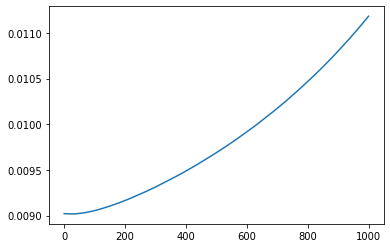

In [19]:
loss_fn = loss()

dims = [X_train.shape[0], 10, Y_train.shape[0]]

model = Perceptron(dims)
loss_history = train_loop(X_train, Y_train, model, loss_fn, epochs = 1000, learning_rate = 0.0001)

plt.plot(loss_history)

In [22]:
Y_pred = model.forward(X = X_test, y = Y_test)

In [23]:
Y_pred

array([[0.16426951, 0.0399721 , 0.13883711, ..., 0.17325418, 0.09412282,
        0.04520539],
       [0.07895771, 0.10158257, 0.06051278, ..., 0.08190197, 0.08935089,
        0.12840983],
       [0.14779556, 0.04668969, 0.11072763, ..., 0.14999732, 0.11302304,
        0.05264164],
       ...,
       [0.03653363, 0.20733829, 0.07635253, ..., 0.03921055, 0.12071302,
        0.16380433],
       [0.10672156, 0.07546361, 0.09657794, ..., 0.08873747, 0.08007232,
        0.10998589],
       [0.03814542, 0.20416523, 0.08345839, ..., 0.0379778 , 0.11535812,
        0.16278502]])

In [24]:
Y_pred = np.argmax(Y_pred, axis = 0)

In [25]:
Y_pred

array([0, 7, 0, ..., 0, 7, 7], dtype=int64)

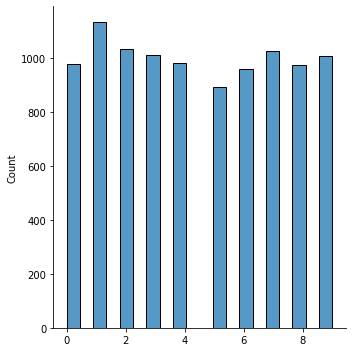

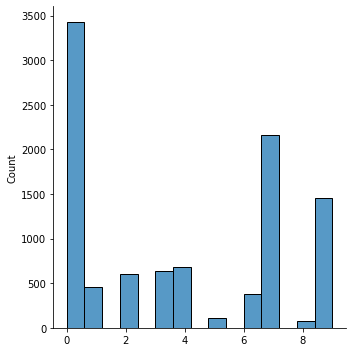

In [28]:
sns.displot(np.argmax(Y_test, axis = 0))
sns.displot(Y_pred)